# Problem Set 7
In this problem set you will implement Newton's Method, and L-BFGS, a memory-efficient version of BFGS.

# Problem 1: Newton's Method

This problem will demonstrate the two convergence behaviors of Newton's method, damped and quadratic, by simulation.

Consider $f_m(x) = \|x\|^3 + \frac{m}{2}\|x\|^2$ for $m \in \{0, 0.0001, 0.001, 0.1\}$ and $x \in \mathbb{R}^5$.




## Part (A)
For each $m$, implement Newton's method on $f_m(x)$ and provide the convergence plots, i.e $\log(\|x^{(k)} - x^{\ast}\|^2)$ vs. iteration $k$. Use the constant step size $t=1$.


In order to solve this function ($f_m(x) = \|x\|^3 + \frac{m}{2}\|x\|^2$), we need to calculate the first derivative (gradient) and the second (Hessian) for the Newton's method update.
Use a constant step size t=1.
Convergence can be monitored by plotting $\log(\|x^{(k)} - x^{\ast}\|^2)$ against iterations.
$m \in \{0, 0.0001, 0.001, 0.1\}$ and $x \in \mathbb{R}^5$.

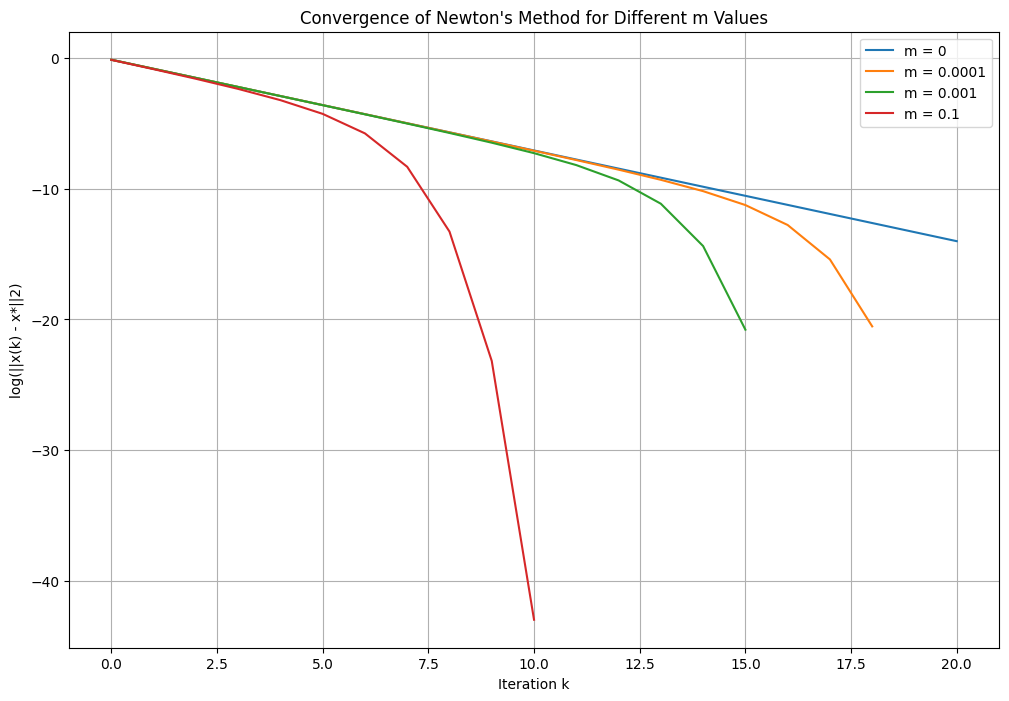

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# define f of m
def f_m(x, m):
    return np.linalg.norm(x)**3 + (m/2) * np.linalg.norm(x)**2

#define gradient
# the gradient isn't simply  f_m'(x) = 3x^2 + mx as x is vector and not scalar, so needs to use norm

def gradient_f_m(x, m):
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        return np.zeros_like(x)  # to fix the divide by zero issue
    else:
        return 3 * norm_x * x + m * x

#define Hessian
# similarly, 6x+mI doesn't directly apply. nvolves terms that reflect the curvature of the function in all directions in r5
# the term (3 * norm_x + m) * I + 3 * np.outer(x, x) / norm_x reflects the contribution from the quadratic term and the influence of the cubic term

def hessian_f_m(x, m):
    norm_x = np.linalg.norm(x)
    I = np.eye(len(x))
    if norm_x == 0:
        return m * I  # to avoid division by zero -
    else:
        return (3 * norm_x + m) * I + 3 * np.outer(x, x) / norm_x

# Implement Newton's method
def newtons_method(m, x0, max_iter=50, tol=1e-6):
    x = x0
    x_star = np.zeros_like(x0)
    convergence = []

    for k in range(max_iter):
        grad = gradient_f_m(x, m)
        hess = hessian_f_m(x, m)
        x_new = x - np.linalg.inv(hess) @ grad  #update step

        # use L2 norm of difference
        conv_measure = np.log(np.linalg.norm(x_new - x_star))
        convergence.append(conv_measure)

        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new

    return convergence

# intial guess
x0 = np.random.rand(5)  # Random initial guess in R^5

# Values of m
m_values = [0, 0.0001, 0.001, 0.1]

# Plot convergence for each m
plt.figure(figsize=(12, 8))

for m in m_values:
    convergence = newtons_method(m, x0)
    plt.plot(convergence, label=f'm = {m}')

plt.xlabel('Iteration k')
plt.ylabel('log(||x(k) - x*||2)')
plt.title('Convergence of Newton\'s Method for Different m Values')
plt.legend()
plt.grid(True)
plt.show()


## Part (B)
Using the condition for quadratic convergence, explain how and why your result changes according to $m$.

Each plot represents the logarithm of the L2 norm of the difference between the current estimate and the minimizer, against the number of iterations.

These plots demonstrate how the convergence behavior of Newton's method varies with different values of m. It can be observed the speed and pattern of convergence, illustrating both damped and quadratic convergence behaviors depending on the choice of m.
For m=0, the function simplifies to f(0) =∥x∥^3. The lack of a quadratic term  affects the function's curvature and the informativeness of the Hessian near the minimum, which in turn impacts the ability of Newton's method to achieve quadratic convergence.

The quadratic conversion in this plot is characterized by a very rapid decrease in the error as the iterates approach the solution.
This is because plotting the logarithm of the error magnifies the rate of decrease, making quadratic convergence appear as a steeply declining line.
For the other values of m (0.0001, 0.001, 0.1), the presence of the quadratic term $\frac{m}{2}\|x\|^2$ significantly affects the behavior of both the gradient and the Hessian, influencing the convergence properties of Newton's method.
Higher values of m generally improve the conditioning of the problem, making it converges faster and the Hessian more reliably positive definite.
Also, values of m greater than zero help ensure the gradient is never zero (except at the optimum x = 0), making it more reliable.

# Problem 2: BFGS

Download the file BFGS.zip. There you will find matrices and vectors defining two functions: $0.5x^{\top}M_1{x} - {b}_1x$, and $0.5x^{\top}M_2{x} - {b}_2x$. The solution, ${x}^{\ast}$, is there as well, although this is easy to find since both $M_1$ and $M_2$ are invertible, and hence you can just set it equal to zero and solve.

Use BFGS to solve the two quadratic problems above. Note that for non-quadratic problems, as with Newton's method, BFGS should use an approximate line search. In this quadratic case, however, use an exact line search. Plot the error, $\log(\|{x}^{(k)} - {x}^{\ast}\|_{M_i}^2)$ vs. iteration $k$ for both.

In [ ]:
import zipfile as zipfile
import pandas as pd
import numpy as np

%matplotlib inline

def loaddata(filename):
    data={}
    with zipfile.ZipFile(filename) as z:
        for filename in z.namelist():
          if 'MAC' in filename:
            continue
          else:
            data[filename] = pd.read_csv(z.open(filename), sep=',', header=None)
    return data

bfgs_dict = loaddata('./BFGS.zip')
print(bfgs_dict.keys())
b1_bfgs = bfgs_dict['b1.csv']
b2_bfgs = bfgs_dict['b2.csv']
M1_bfgs = bfgs_dict['M1.csv']
M2_bfgs = bfgs_dict['M2.csv']
x_bfgs = bfgs_dict['x.csv']

dict_keys(['b1.csv', 'b2.csv', 'M1.csv', 'M2.csv', 'x.csv'])


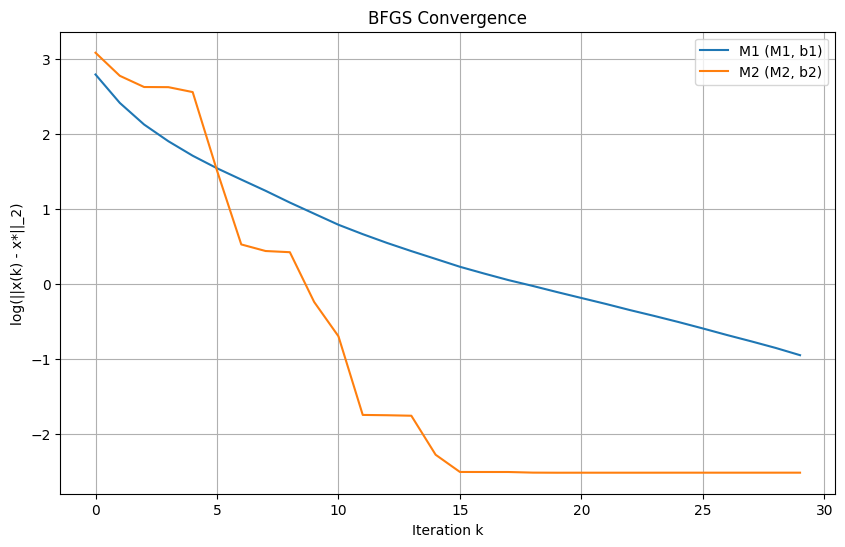

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#gradient function
def grad_quadratic_function(x, M, b):
  #gradient of the quadratic function 0.5*x^T*M*x - b^T*x
  return np.dot(M, x) - b

#bfgs
def bfgs_method(M, b, x_star, max_iter=100, reset_threshold=1e-8):
  n = b.shape[0]
  #initialize the vector
  x = np.zeros((n, 1))
  # identity matrix
  B = np.eye(n)
  errors = []

  for k in range(max_iter):
    #compute the gradient
    grad = grad_quadratic_function(x, M, b)
    # compute the search direction
    p = -np.linalg.solve(B, grad)
    #perform the exact line search
    step_size = - (np.dot(grad.T, p)) / (np.dot(np.dot(p.T, M), p))

    # check if the step size is too small and reset if necessary
    if np.abs(step_size) < reset_threshold:
      step_size = reset_threshold

    x_new = x + step_size * p

    # update B using BFGS formula
    s = x_new - x
    y = grad_quadratic_function(x_new, M, b) - grad

    # check if the Hessian approximation is far from being positive definite
    if np.dot(s.T, y) <= reset_threshold * np.dot(y.T, y):
      # reset the Hessian approximation
      B = np.eye(n)
    else:
      Bs = np.dot(B, s)
      B += np.outer(y, y) / np.dot(y.T, s) - np.outer(Bs, Bs) / np.dot(s.T, Bs)


    # Compute error and check for convergence
    error = np.log(np.linalg.norm(x_new - x_star))
    errors.append(error)

    x = x_new

  return errors

# Solve and plot for both problems
errors_M1 = bfgs_method(M1_bfgs, b1_bfgs, x_bfgs, max_iter=30)
errors_M2 = bfgs_method(M2_bfgs, b2_bfgs, x_bfgs, max_iter=30)

plt.figure(figsize=(10, 6))
plt.plot(errors_M1, label='M1 (M1, b1)')
plt.plot(errors_M2, label='M2 (M2, b2)')
plt.xlabel('Iteration k')
plt.ylabel('log(||x(k) - x*||_2)')
plt.title('BFGS Convergence')
plt.legend()
plt.grid(True)
plt.show()

The plot shows the convergence of the BFGS method applied to M1 and M2. The y-axis  indicates the logarithm of the norm of the error and x-axis show the iteration count.

As observed, both curves trend downward, which suggests the BFGS algorithm is converging towards the solution for both problems. This should be the expected behavior.

Notes: There is a rapid decline in error, which is good and indicates progress toward the optimum solution. After the rapid decrese, it levels off as the solution is approached and the improvements are smaller.
The negative value of the norm, it just means the error is less than 1.




# Problem 3: BFGS on Digits Dataset
Again we consider the same logistic regression problem we have encountered on the past problem set. As a brief reminder, logistic regression ultimately involves minimize the negative log likelihood:

$$
\min_\mathbf{b} \ell(\mathbf{b}) = -\log p(\textbf{y}|X, \mathbf{b}) = \sum_{i=1}^N \left( b_{y_i}^\top x_i + \log{\sum_{j=1}^C e^{-b_j^\top x_i}} \right).
$$


Recall that the data in (with inputs $X$ and labels $\textbf{y}$) are separated into test and
train. Perform optimization using the training data, and record performance using the test data.

Run BFGS on the **digits.zip** data set from the past homework, and plot your results.


In [ ]:
def loaddata(filename):
    data={}
    with zipfile.ZipFile(filename) as z:
        for filename in z.namelist():
          data[filename] = pd.read_csv(z.open(filename), sep=' ', header=None).to_numpy()
    return data

digits_dict = loaddata('./digits.zip')
print(digits_dict.keys())
X_digits_train = digits_dict['X_digits_train.csv']
X_digits_test = digits_dict['X_digits_test.csv']
y_digits_train = digits_dict['y_digits_train.csv'].ravel()
y_digits_test = digits_dict['y_digits_test.csv'].ravel()

dict_keys(['X_digits_test.csv', 'X_digits_train.csv', 'y_digits_test.csv', 'y_digits_train.csv'])


Optimization terminated successfully.
         Current function value: -0.011978
         Iterations: 176
         Function evaluations: 181
         Gradient evaluations: 181
Training Accuracy: 1.0
Test Accuracy: 0.8263772954924875


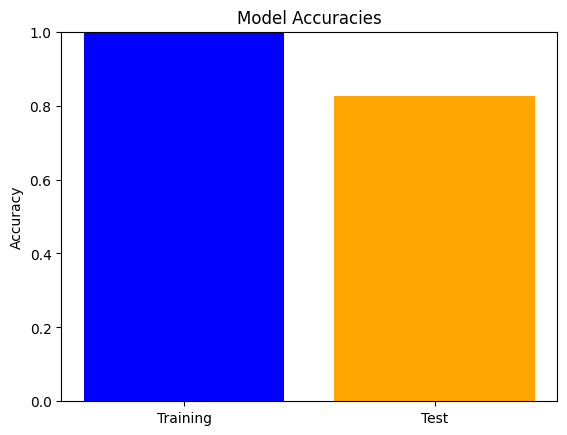

In [ ]:
#print(X_digits_train.shape)
#print(X_digits_test.shape)
#print(y_digits_train.shape)
#print(y_digits_test.shape)

import numpy as np
from scipy.optimize import fmin_bfgs
import seaborn as sns

# softmax function to convert logits to probabilities
def softmax(z):
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
  return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# negative log likelihood
def neg_log_likelihood(params, X, y, num_classes):
  # reshape into a weight matrix
  weights = params.reshape((X.shape[1], num_classes))
  logits = np.dot(X, weights)
  # calculate the probabilities using the softmax
  probs = softmax(logits)
  # create a endoding of labels
  y_encoding = np.eye(num_classes)[y.astype(int)]
  loss = -np.sum(y_encoding * np.log(probs + 1e-5))
  # added a small constant to fix the log(0) issue
  return loss

# gradient with respects to the weights
def gradient(params, X, y, num_classes):
  weights = params.reshape((X.shape[1], num_classes))
  logits = np.dot(X, weights)
  probs = softmax(logits)
  y_encoding = np.eye(num_classes)[y.astype(int)]
  grad = np.dot(X.T, probs - y_encoding)
  return grad.flatten()

# to train the model
def train_softmax_regression(X_train, y_train, num_classes):
  num_features = X_train.shape[1]
  initial_params = np.zeros((num_features * num_classes,))

  # Use bfgs implementation from scipy.optimize so we don't reinvent the wheel
  params_opt = fmin_bfgs(neg_log_likelihood, initial_params, fprime=gradient,
                         args=(X_train, y_train, num_classes), maxiter=10000)
  return params_opt.reshape((num_features, num_classes))

num_classes = len(np.unique(y_digits_train))
weights_optimized = train_softmax_regression(X_digits_train, y_digits_train, num_classes)

def predict(X, weights):
  logits = np.dot(X, weights)
  probs = softmax(logits)
  return np.argmax(probs, axis=1)

# Evaluate the model
y_pred_train = predict(X_digits_train, weights_optimized)
y_pred_test = predict(X_digits_test, weights_optimized)

# Calculate accuracy
accuracy_train = np.mean(y_digits_train == y_pred_train)
accuracy_test = np.mean(y_digits_test == y_pred_test)

print("Training Accuracy:", accuracy_train)
print("Test Accuracy:", accuracy_test)

# Plot accuracy results for both training and test sets
accuracies = {'Training': accuracy_train, 'Test': accuracy_test}
fig, ax = plt.subplots()
ax.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange'])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Problem 4: L-BFGS (Optional)
Read about L-BFGS -- a memory efficient approximation to BFGS. Compare the iteration and
computational complexity of BFGS with L-BFGS for varying values of $m$, the
length of the stored history. Using several values of $m$, plot the test loss
$\ell(\mathbf{b})$ against the number of iterations and (separately) against the
computation time for both BFGS and L-BFGS. Discuss the difference in
performance in terms of iteration complexity and computation time. How does $m$
affect this relationship?
